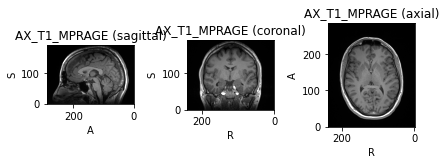

In [176]:
import os
import torchio as tio
import SimpleITK as sitk

input_path = "../data/nifti/AX_T1_MPRAGE.nii.gz"

# On vérifie que le fichier Nifti existe
if not os.path.exists(input_path):
    raise ValueError(f"Ce chemin n'existe pas  : {input_path}")

def plot(*images):
    subject = tio.Subject(temp=tio.ScalarImage(images[0]))
    if len(images) > 1:
        for img in images:
            subject.add_image(tio.ScalarImage(img), os.path.basename(img).replace(".nii.gz", ""))
    else:
        subject.add_image(tio.ScalarImage(images[0]), os.path.basename(images[0]).replace(".nii.gz", ""))

    subject.remove_image("temp")
    subject.plot()

plot(input_path)

In [119]:
def BrainExtractionTool(input_path, output_suffixe="brain", mask=False):
    """ Extract brain from a Nifti image

    Parameters
    ----------
    input_path : str
        Nifti file path

    output_suffixe : str
        Nifti file suffixe for the new generated image

    mask : bool
        Nifti file path containing the brain binarized mask 

    """
    # Path of the executable BSE script of Brainsuite
    BSE = "bse.exe"

    output_path = input_path.replace(".nii.gz", "_"+output_suffixe+".nii.gz")
    if mask == False:
        command = f"{BSE} -i \"{input_path}\" -o \"{output_path}\" --auto"
    else:
        mask_path = output_path.replace(".nii.gz", "_mask.nii.gz")
        command = f"{BSE} -i \"{input_path}\" -o \"{output_path}\" --mask \"{mask_path}\" --auto"

    print(command)

    os.system(command)

In [120]:
# On lance la fonction d'extraction de cerveau
BrainExtractionTool(input_path, mask=True)

bse.exe -i "../data/nifti/AX_T1_MPRAGE.nii.gz" -o "../data/nifti/AX_T1_MPRAGE_brain.nii.gz" --mask "../data/nifti/AX_T1_MPRAGE_brain_mask.nii.gz" --auto


In [125]:
def n4BiasFieldCorrection(input_path, output_suffixe="corrected", mask=False):
    """ Correct the bias field correction

    Parameters
    ----------
    input_path : str
        Nifti file path

    output_suffixe : str
        Nifti file suffixe for the new generated image

    mask_path : str
        Nifti file path containing the mask of the bias field

    """
    output_path = input_path.replace(".nii.gz", "_"+output_suffixe+".nii.gz")
    nifti = sitk.ReadImage(input_path)

    mask_otsu = sitk.OtsuThreshold(nifti,0,1,200)
    if mask == True:
        mask_path = output_path.replace(".nii.gz", "_mask.nii.gz")
        sitk.WriteImage(mask_otsu, mask_path)

    nifti = sitk.Cast(nifti, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()

    output = corrector.Execute(nifti, mask_otsu)

    sitk.WriteImage(output, output_path)

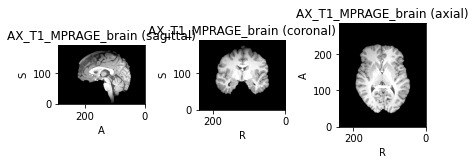

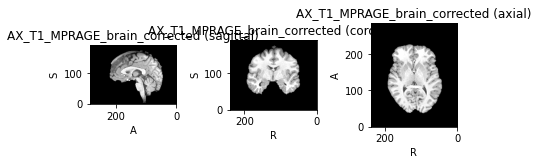

In [183]:
# On définit les chemins pour les données qui vont être générées
input_path = "../data/nifti/AX_T1_MPRAGE_brain.nii.gz"

# On lance la fonction d'extraction de cerveau
n4BiasFieldCorrection(input_path, mask=True)

plot(input_path)
plot("../data/nifti/AX_T1_MPRAGE_brain_corrected.nii.gz")

In [127]:
def registration(atlas_path, input_path, output_suffixe="flirt"):
    """ Register a nifti image to an atlas (MNI152)

    Parameters
    ----------
    atlas_path : str
        Nifti file path which is the atlas 

    input_path : str
        Nifti file path to be registered

    output_suffixe : str
        Nifti file suffixe for the new generated image

    """
    fixed = sitk.ReadImage(atlas_path, sitk.sitkFloat32)
    moving = sitk.ReadImage(input_path, sitk.sitkFloat32)

    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsMeanSquares()
    R.SetOptimizerAsRegularStepGradientDescent(4.0, 0.01, 2000)
    R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
    R.SetInterpolator(sitk.sitkLinear)

    outTx = R.Execute(fixed, moving)
    resampled = sitk.Resample(moving,
                                fixed,
                                outTx,
                                sitk.sitkLinear, 0.0,
                                moving.GetPixelIDValue())

    output_path = input_path.replace(".nii.gz", "_"+output_suffixe+".nii.gz")
    sitk.WriteImage(resampled, output_path)

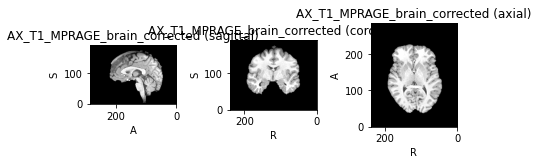

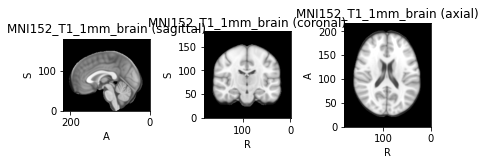

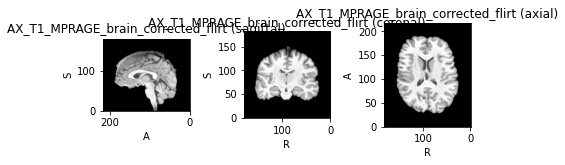

In [182]:
# On définit les chemins pour les données qui vont être générées
input_path = "../data/nifti/AX_T1_MPRAGE_brain_corrected.nii.gz"
atlas_path = "../data/nifti/atlas/MNI152_T1_1mm_brain.nii.gz"

# On lance la fonction d'extraction de cerveau
# registration(atlas_path, input_path)

plot(input_path)
plot(atlas_path)
plot("../data/nifti/AX_T1_MPRAGE_brain_corrected_flirt.nii.gz")

In [174]:
def resample(*values):
    """ Resample images in the same space with a resample factor. If no resample factor is given, the first image become the fixed image and all others paths will be resampled on it

    Parameters
    ----------
    input_paths : str 
        All the image paths which need to be resampled on a fixed image or on a resampled value

    resample : int (optional)
        The resample value in which all the image will be transformed.

    
    Example
    -------
    resample(t1_path, 1) => the t1_path is resampled with 1mm voxel size
    resample(t1_path, t2_path) => t1_path is the fixed image, t2_path is the moving image
    resample(t1_path, t2_path, swi_path, 2) => all images are resampled with 2mm voxel size
    resample(t1_path) => Not working because if there is any resample value, 2 paths are mendatory
    """
    paths = []
    transform = None
    for value in values:
        if type(value) == str and os.path.exists(value):
            paths.append(value)

        elif type(value) == int:
            transform = tio.Resample(value)

    if len(paths) > 0:
        if transform == None:
            if len(paths) >= 2:
                subject = tio.Subject(ref=tio.ScalarImage(paths.pop(0)))

                for path in paths:
                    subject.add_image(tio.ScalarImage(path), path)

                transform = tio.Resample("ref")
                subject = transform(subject)

                for image in subject.get_images_names():
                    if image != "ref":
                        subject[image].save(image.replace(".nii.gz", "_resampled.nii.gz"))
            else:
                raise ValueError("Need at least 2 valid paths (1 as ref, 1 as resampled) when no resampling value is given")
        else:
            subject = tio.Subject(ref=tio.ScalarImage(paths[0]))
            for path in paths:
                subject.add_image(tio.ScalarImage(path), path)

            subject = transform(subject)

            for image in subject.get_images_names():
                if image != "ref":
                    subject[image].save(image.replace(".nii.gz", "_resampled.nii.gz"))

    else:
        raise ValueError("All the given path were not valid")

('../data/nifti/atlas/MNI152_T1_1mm_brain.nii.gz', '../data/nifti/AX_T1_MPRAGE_brain_corrected.nii.gz')


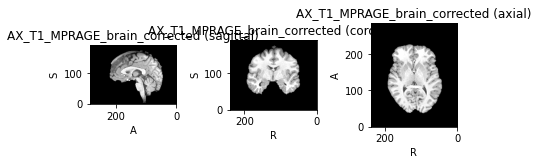

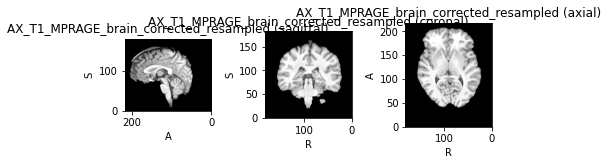

In [177]:
input_path = "../data/nifti/AX_T1_MPRAGE_brain_corrected.nii.gz"
atlas_path = "../data/nifti/atlas/MNI152_T1_1mm_brain.nii.gz"
resampled = 1
resample(atlas_path, input_path)

plot(input_path)
plot("../data/nifti/AX_T1_MPRAGE_brain_corrected_resampled.nii.gz")

In [134]:
def histogram_matching(input_ref_path, input_path, output_suffixe="hm"):
    """ Match the histogram of two images.

    Parameters
    ----------
    input_ref_path : str
        The fixed image on which the other image will be matched

    input_path : str 
        The moving image that needs to be filtered

    output_suffixe : str
        Nifti file suffixe for the new generated image
    """
    him = sitk.HistogramMatchingImageFilter()
    him.SetThresholdAtMeanIntensity(True)

    readerI = sitk.ImageFileReader()
    readerI.SetFileName(input_path)
    in_img = readerI.Execute()

    readerII = sitk.ImageFileReader()
    readerII.SetFileName(input_ref_path)
    ref = readerII.Execute()

    out_img = him.Execute(in_img,ref)

    writer = sitk.ImageFileWriter()

    output_path = input_path.replace(".nii.gz", "_"+output_suffixe+".nii.gz")

    writer.SetFileName(output_path)
    writer.Execute(out_img)

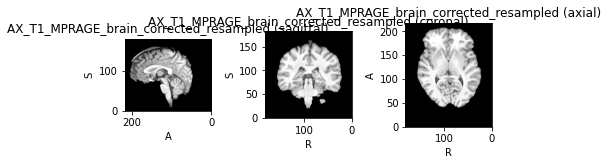

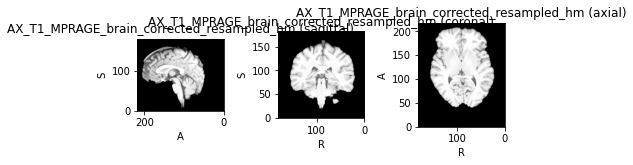

In [179]:
# On définit les chemins pour les données qui vont être générées
input_path = "../data/nifti/AX_T1_MPRAGE_brain_corrected_resampled.nii.gz"
ref_path = "../data/nifti/atlas/MNI152_T1_1mm_brain.nii.gz"

# On lance la fonction d'extraction de cerveau
histogram_matching(ref_path, input_path)

plot(input_path)
plot("../data/nifti/AX_T1_MPRAGE_brain_corrected_resampled_hm.nii.gz")